In [1]:
# standard imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt
import sys

# custom imports
sys.path.append('../src')
from fetch_range_data import fetch_range_data

# Bitcoin

The purpose of this notebook is to explore methods of bitcoin price forecasting

## Get today's data

In [2]:
# get today's data with custom function
today = dt.date.today() 
first_date = '2015/07/20'
btc = fetch_range_data('BTC/USD', first_date, today)

File exists, returned as df


In [3]:
btc.sort_index()

,date,unix,low,high,open,close,volume,vol_fiat
0,2015-11-22,1448150400,321.00,327.00,326.99,323.71,3426.178602,1.109088e+06
1,2015-11-21,1448064000,316.33,328.00,322.39,327.00,5125.958809,1.676189e+06
2,2015-11-20,1447977600,311.23,327.04,326.53,322.39,9324.440814,3.006106e+06
3,2015-11-19,1447891200,324.90,336.38,335.50,326.41,6720.695931,2.193702e+06
4,2015-11-18,1447804800,330.00,338.00,336.49,335.49,5204.310117,1.745994e+06
...,...,...,...,...,...,...,...,...
2349,2020-10-31,1604102400,13424.73,14098.92,13571.51,13804.81,12166.304298,1.679535e+08
2350,2020-10-30,1604016000,13131.31,13687.82,13460.00,13571.51,15664.290475,2.125881e+08
2351,2020-10-29,1603929600,12976.29,13650.00,13281.06,13460.00,15796.076677,2.126152e+08
2352,2020-10-28,1603843200,12891.57,13863.87,13740.85,13281.05,21073.376678,2.798766e+08


## Relabel Data

### Explore special values for BTC

In [4]:
# rename columns of btc dataframe
my_dict = {'date': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume':'Volume', 'vol_fiat':'Market Cap'}
btc.rename(columns=my_dict, inplace=True)

btc.shape

(2354, 8)

### Convert Index to Datetime

In [5]:
# change btc index to Date column datetime objects
btc.set_index(pd.to_datetime(btc['Date']),inplace=True)

In [6]:
# sort index for ease of comparison
btc.sort_index(inplace=True)
btc

,Date,unix,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,,,
2015-07-20,2015-07-20,1437350400,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,2015-07-21,1437436800,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,2015-07-22,1437523200,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,2015-07-23,1437609600,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,2015-07-24,1437696000,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...,...,...
2021-08-18,2021-08-18,1629244800,44216.47,46035.27,44675.34,44707.98,10327.498874,4.617216e+08
2021-08-19,2021-08-19,1629331200,43955.00,47088.08,44709.10,46765.87,11938.121850,5.582967e+08
2021-08-20,2021-08-20,1629417600,46644.95,49400.00,46769.02,49342.40,13184.670486,6.505633e+08


In [7]:
type(btc.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [8]:
btc.columns

Index(['Date', 'unix', 'Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

### Resampling

In [9]:
btcM = btc.resample('M').mean()
btcM

,unix,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,,
2015-07-31,1.437826e+09,283.055000,289.198333,285.987500,286.595833,4931.954199,1.416845e+06
2015-08-31,1.439683e+09,246.512581,257.395806,253.492903,251.755161,7230.025266,1.765739e+06
2015-09-30,1.442318e+09,231.936000,236.955000,234.163000,234.365000,6386.535932,1.495726e+06
2015-10-31,1.444954e+09,261.374839,269.491613,263.724516,266.229032,7850.672554,2.159975e+06
2015-11-30,1.447589e+09,334.626000,362.877000,347.445000,349.508000,12491.747698,4.548917e+06
...,...,...,...,...,...,...,...
2021-04-30,1.618488e+09,55321.213333,58500.627000,57131.086000,57097.920667,15581.189920,8.804247e+08
2021-05-31,1.621123e+09,44270.166129,48889.056129,47119.199677,46457.782903,29742.506763,1.294962e+09
2021-06-30,1.623758e+09,34303.263667,37144.137000,35916.499000,35842.765667,19942.838788,7.051311e+08


In [10]:
btcD = btcM.resample('D').mean()
btcD

,unix,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,,
2015-07-31,1.437826e+09,283.055000,289.198333,285.987500,286.595833,4931.954199,1.416845e+06
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualizations

In [11]:
# create xticklabels
xticks_min = []
xticks_maj = []
xlabels_min = []
xlabels_maj = []
year = 0
month = 0

for index in btc.index:
    if year != index.year:
        year = index.year
        xticks_maj.append(index)
        xlabels_maj.append(year)
    if month != index.month:
        month = index.month
        xticks_min.append(index)
        xlabels_min.append(month)


In [12]:
xlabels_min

[7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8]

Text(0.5, 1.0, 'Bitcoin Price over Time')

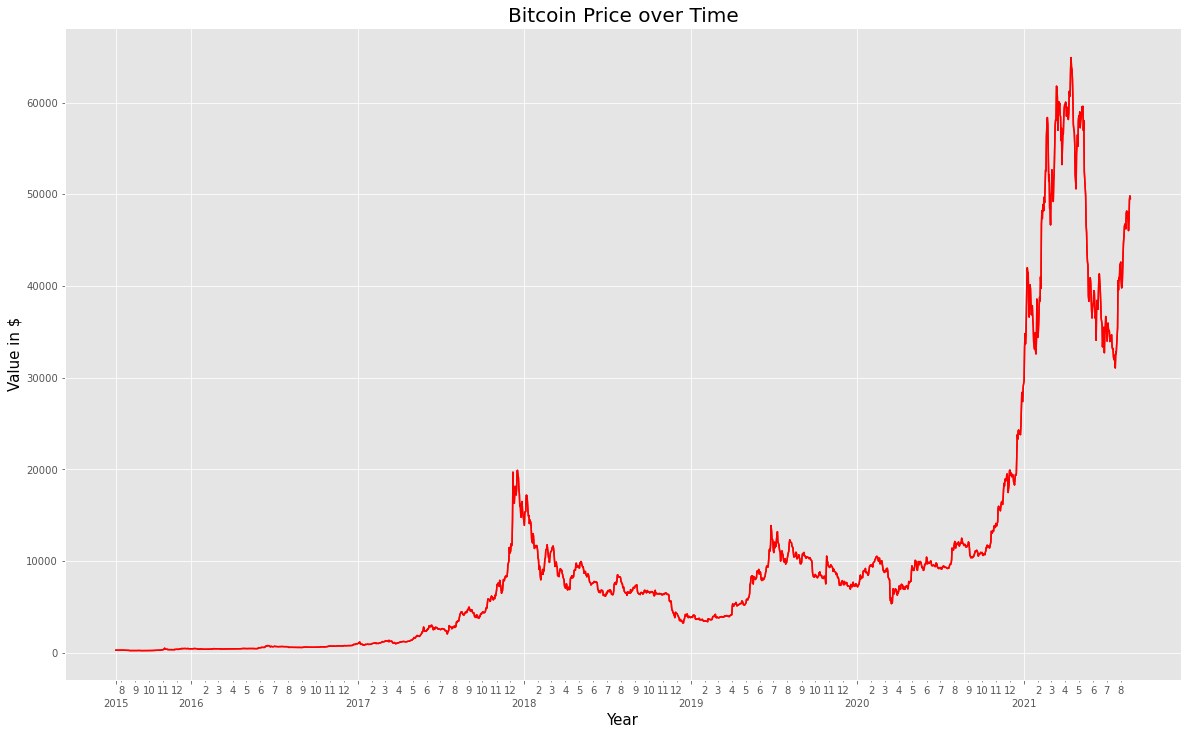

In [13]:
# plot daily high values of data
plt.style.use('ggplot')
figsize = (20,12)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.plot(btc.index, btc.High, c='r', lw=1.5)

ax.set_xticks(xticks_min, minor=True)
ax.set_xticklabels(xlabels_min, minor=True)
ax.set_xticks(xticks_maj, minor=False)
ax.set_xticklabels(xlabels_maj, minor=False)

ax.tick_params(axis='x', which='major', direction='out', rotation=0, pad=15)
ax.tick_params(axis='x', which='minor', direction='out', rotation=0)

ax.set_xlabel("Year", fontsize=15, color='black')
ax.set_ylabel('Value in $', fontsize=15, color='black')
ax.set_title('Bitcoin Price over Time', fontsize=20, color='black')
# plt.savefig('bitcoin_historical_transparent.png', transparent=True, dpi=400)
# plt.savefig('bitcoin_historical.png', transparent=False, dpi=400)

Text(0.5, 1.0, 'Bitcoin Daily Closing Price')

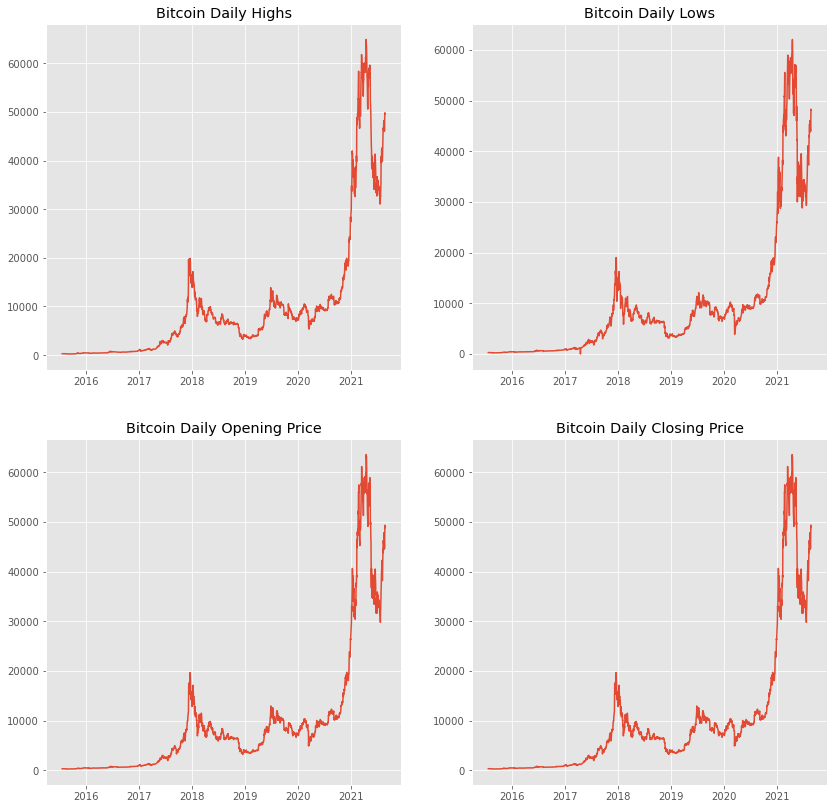

In [14]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening Price')
ax[1,1].set_title('Bitcoin Daily Closing Price')

Text(0.5, 1.0, 'Bitcoin Daily Closing')

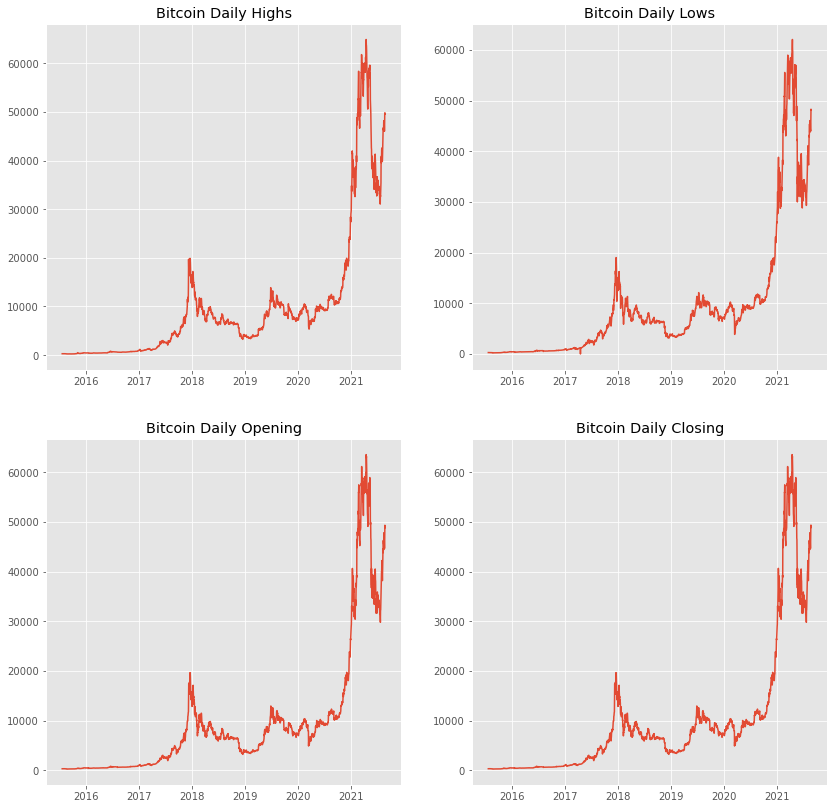

In [15]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening')
ax[1,1].set_title('Bitcoin Daily Closing')

# First Simple Model - Random Walk

In [16]:
end_of_train_index = int(btc.shape[0]*0.8)
end_of_train_index

1883

In [17]:
# separate train and test data
# roughly first 80% of data
train = btc.Close[:end_of_train_index]

# roughly last 20% of data
test = btc.Close[end_of_train_index:]

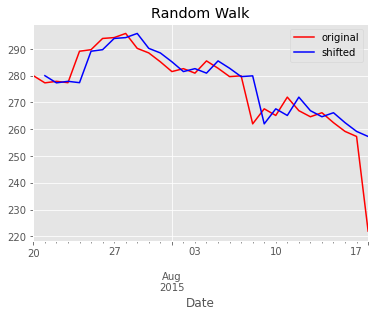

In [18]:
# create "random walk" model, shift values by 1 day
random_walk = train.shift(1)

# create plot of first 30 values of train and random walk
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [19]:
random_walk.dropna(inplace=True)

In [20]:
import sklearn.metrics as metric

In [21]:
train.shape[0]

1883

In [22]:
random_walk[:3]

Date
2015-07-21    280.00
2015-07-22    277.32
2015-07-23    277.89
Name: Close, dtype: float64

In [23]:
train[:3]

Date
2015-07-20    280.00
2015-07-21    277.32
2015-07-22    277.89
Name: Close, dtype: float64

In [24]:
train.index

DatetimeIndex(['2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29',
               ...
               '2020-07-28', '2020-07-29', '2020-07-29', '2020-07-30',
               '2020-07-30', '2020-07-31', '2020-07-31', '2020-08-01',
               '2020-08-01', '2020-08-02'],
              dtype='datetime64[ns]', name='Date', length=1883, freq=None)

In [25]:
random_walk.index

DatetimeIndex(['2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24',
               '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28',
               '2015-07-29', '2015-07-30',
               ...
               '2020-07-28', '2020-07-29', '2020-07-29', '2020-07-30',
               '2020-07-30', '2020-07-31', '2020-07-31', '2020-08-01',
               '2020-08-01', '2020-08-02'],
              dtype='datetime64[ns]', name='Date', length=1882, freq=None)

In [26]:
metric.mean_squared_error(train[1:], random_walk)

91437.44530456958

In [30]:
metric.mean_squared_log_error(train['2015-07-21':'2015-08-30'], random_walk['2015-07-21':'2015-08-30'])

0.001077400777264864

## ARIMA MODEL

In [55]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [125]:
# create timeseriessplit object
data = btc.Close
n = 5
tss = TimeSeriesSplit(n_splits = n)
split_data = tss.split(data)

In [126]:
# save split data for time series cross val
i = 0
tss_train = []
tss_test = []
for j, k in split_data:
    # use globals to save 
    tss_train.append(j)
    tss_test.append(k)
    
tss_train = np.array(tss_train)
tss_test = np.array(tss_test)

In [127]:
# define function to print min and max of array/list
def print_info(input_):
    min_value = min(input_) 
    max_value = max(input_)
    
    return f'min: {min_value} max: {max_value}\n'

In [129]:
# iterate thgouh timeseriessplit object and print info
for train_index, test_index in tss_train, tss_test:
    print('Train:', print_info(train_index))
    print('Test:', print_info(test_index))

ValueError: too many values to unpack (expected 2)

In [51]:
test_index[1]

1963

In [53]:
x = btc['Close'].iloc[train_index[0]]
x
# x.append(btc['Close'].iloc[train_index[1]])
# x

280.0

In [56]:
# CREATE arima_model object, pass training set and order

# (0,1,0) as the order means 1st order differenced model, essentially a random walk

rw = ARIMA(train, (0,1,0), freq='D').fit()

y_hat = rw.predict(typ='levels')
y_hat

ValueError: endog and exog matrices are different sizes

In [39]:
# find squared error and compare to random walk model generated manually
metric.mean_squared_error(train[1:], y_hat)

1729.429428266681

In [40]:
# per answer above, essentially random walk model

In [41]:
# CREATE arima_model object, pass training set and order

# (1,1,0) as the order means 1st order differenced model, with additional lag

ar_1 = ARIMA(train, (1,1,0), freq='D').fit()

y_hat = ar_1.predict(typ='levels')
y_hat

2013-04-29     136.896156
2013-04-30     147.409508
2013-05-01     141.488836
2013-05-02     119.083772
2013-05-03     107.549158
                 ...     
2017-08-23    4105.511149
2017-08-24    4155.365055
2017-08-25    4341.695164
2017-08-26    4375.107320
2017-08-27    4354.561175
Freq: D, Length: 1582, dtype: float64

In [42]:
metric.mean_squared_error(train[1:], y_hat)

1728.433415133815

In [43]:
# CREATE arima_model object, pass training set and order

# try higher order models

ar_2 = ARIMA(train, (1,2,1), freq='D').fit()

y_hat = ar_2.predict(typ='levels')
y_hat

2013-04-30     154.885044
2013-05-01     141.386915
2013-05-02     111.216079
2013-05-03      97.990709
2013-05-04      90.514020
                 ...     
2017-08-23    4121.901447
2017-08-24    4173.047590
2017-08-25    4358.432240
2017-08-26    4394.950258
2017-08-27    4375.102446
Freq: D, Length: 1581, dtype: float64

In [44]:
metric.mean_squared_error(train[2:], y_hat)

1712.4775402782118

In [45]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 1581
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -8130.940
Method:                       css-mle   S.D. of innovations             41.378
Date:                Thu, 12 Aug 2021   AIC                          16269.879
Time:                        22:40:15   BIC                          16291.343
Sample:                    04-30-2013   HQIC                         16277.854
                         - 08-27-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0150      0.012      1.242      0.214      -0.009       0.039
ar.L1.D2.Close     0.0038      0.025      0.149      0.881      -0.046       0.054
ma.L1.D2.Close    -0.9894      0.004   -230.480      0.000      -0.998      -0.981
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          262.9998           +0.0000j          262.9998            0.0000
MA.1            1.0107           +0.0000j            1.0107            0.0000
-----------------------------------------------------------------------------
"""

In [46]:
# additoinal ARIMIA model
ar_3 = ARIMA(train, (4,2,3), freq='D').fit()

y_hat = ar_3.predict(typ='levels')
y_hat

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


2013-04-30     154.890070
2013-05-01     143.699310
2013-05-02     132.095900
2013-05-03      89.875237
2013-05-04      83.916587
                 ...     
2017-08-23    4061.811764
2017-08-24    4199.758310
2017-08-25    4398.331510
2017-08-26    4337.701088
2017-08-27    4426.505509
Freq: D, Length: 1581, dtype: float64

In [47]:
metric.mean_squared_error(train[2:], y_hat)

1635.6810187215967

In [48]:
# additoinal ARIMIA model
ar_4 = ARIMA(train, (1,1,4), freq='D').fit()

y_hat = ar_4.predict(typ='levels')
metric.mean_squared_error(train[1:], y_hat)

1722.6314650319014

In [49]:
TimeSeriesSplit(5, btc['Close'], max_train_size=0.8*btc.shape[0])

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass max_train_size=Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...   
2018-09-23    6710.63
2018-09-24    6595.41
2018-09-25    6446.47
2018-09-26    6495.00
2018-09-27    6676.75
Name: Close, Length: 1979, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TimeSeriesSplit(max_train_size=Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...
2018-09-23    6710.63
2018-09-24    6595.41
2018-09-25    6446.47
2018-09-26    6495.00
2018-09-27    6676.75
Name: Close, Length: 1979, dtype: float64,
        n_splits=5)

### Make function to make data reshaping easier

In [154]:
# function converts data to array and reshapes for linreg compatibility 
def arr_shape(data):
    data = np.array(data)
    data = data.reshape(-1,1)
    return data

## Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [70]:
btc.shape

(2201, 6)

In [68]:
btc.Close

Date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2021-07-24    34283.01
2021-07-25    35428.26
2021-07-26    37262.77
2021-07-27    39470.48
2021-07-28    40035.10
Name: Close, Length: 2201, dtype: float64

In [139]:
close = btc.Close
close.reset_index(drop=True, inplace=True)
close_index = close.index
close = np.squeeze(close.to_numpy())
close_index = np.squeeze(close_index.to_numpy())

In [153]:
close_index[0]

0

In [155]:
# # separate data for linear regression
X_train, X_test, y_train, y_test = train_test_split(close_index, close)

# reshape for linreg
X_train = arr_shape(X_train)
X_test = arr_shape(X_test)
y_train = arr_shape(y_train)
y_test = arr_shape(y_test)


In [156]:
y_train

array([[ 2786.07],
       [ 4214.84],
       [  238.34],
       ...,
       [ 6928.5 ],
       [ 1292.86],
       [50089.15]])

In [157]:
X_train

array([[ 739],
       [ 807],
       [  73],
       ...,
       [ 985],
       [ 592],
       [2105]], dtype=int64)

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [159]:
preds = lr.predict(X_test)

In [160]:
lr.intercept_

array([-5766.96796992])

In [163]:
lr.coef_

array([[13.56697558]])